In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import KFold
import pandas as pd
import glob
import numpy as np
import os
import scipy as sc

**Getting the data**

In [2]:
# directory for files
os.chdir("C:/Users/adelu/Documents/UZH/Thesis/")
data_dir = "Shared_CallFiles/meerkats/CC/CC_IndividualityWholeGroups_BW/CutAudio_CC_IndividualityWholeGroups_BW/1_Raw/"

audio_files = glob.glob(data_dir + "*")
print(len(audio_files))

# indvidual names from file
ind_name = []
for i in audio_files:
    ind_name.append(i.split("\\")[-1].split("_")[0])
print(ind_name[0])

377
VBBF083


In [3]:
%%time
# load in all files

signals = []
srs = []
times = []

for i in range(len(audio_files)):
    signal, sr = librosa.load(audio_files[i], sr=None)
    time = np.arange(0, len(signal)) / sr

    signals.append(signal)
    srs.append(sr)
    times.append(time)

sr = srs[0]

Wall time: 2.36 s


In [4]:
# indvidual names from file
ind_name = []
for i in audio_files:
    ind_name.append(i.split("\\")[-1].split("_")[0])
print(len(ind_name))

# number of individuals
len(set(ind_name))

377


20

(10, 16)
[[-3.09129822e+02 -2.96864075e+02 -2.99199005e+02 -2.76379425e+02
  -2.66616394e+02 -2.75205109e+02 -2.61085571e+02 -2.48265045e+02
  -2.40222366e+02 -2.11634415e+02 -2.08223648e+02 -2.13677704e+02
  -2.03879227e+02 -2.58995453e+02 -3.13253296e+02 -3.44989929e+02]
 [ 8.73520508e+01  1.04807442e+02  1.08319794e+02  1.32856110e+02
   1.50249435e+02  1.40585144e+02  1.46778473e+02  1.20051971e+02
   1.03438858e+02  1.02550758e+02  8.45763092e+01  8.57615814e+01
   1.08582626e+02  1.30638443e+02  1.27179184e+02  1.08963486e+02]
 [-2.85982780e+01 -2.09125366e+01 -2.34615135e+01 -1.70105171e+01
  -1.99012051e+01 -2.53316059e+01 -2.99501877e+01 -2.98160591e+01
  -2.44726753e+01 -4.56786251e+00 -3.77261853e+00 -7.00450301e-01
  -5.19307709e+00 -2.18788338e+01 -1.13375845e+01 -5.26556396e+00]
 [-3.11827254e+00 -1.54677143e+01 -2.25129032e+01 -1.58676910e+01
  -1.94791107e+01 -2.11682777e+01 -2.56674938e+01 -2.71521664e+01
  -1.13021774e+01 -1.39195833e+01 -1.31769066e+01 -2.39394741e+0

Text(0.5, 1.0, 'delta2')

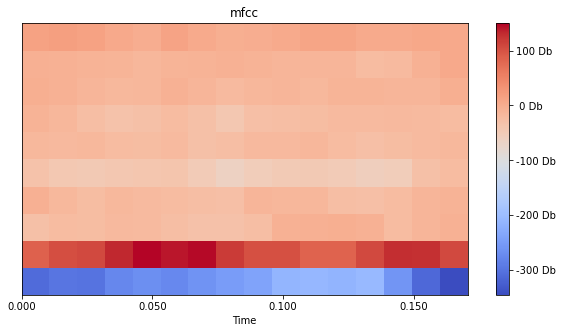

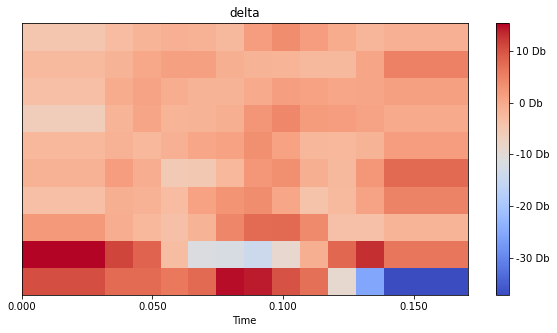

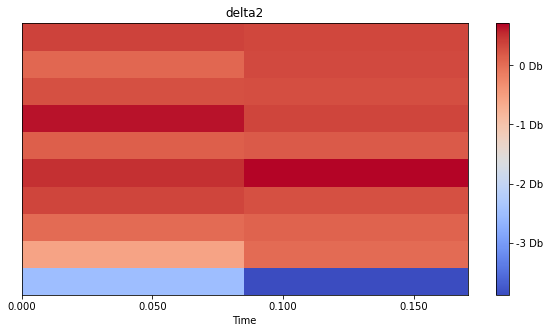

In [7]:
# testing
mfcc = librosa.feature.mfcc(
            signals[0],
            n_mfcc=10,
            sr=sr,
            fmax=10000
            )
print(mfcc.shape)
print(mfcc)


delta = librosa.feature.delta(mfcc, width=5, order=1)
print(delta.shape)

delta_2 = librosa.feature.delta(mfcc, width=15, order=2)
print(delta_2.shape)

plt.figure(figsize=(10, 5))
librosa.display.specshow(mfcc, sr=sr, x_axis="time")
plt.colorbar(format="%2.f Db")
plt.title("mfcc")

plt.figure(figsize=(10, 5))
librosa.display.specshow(delta, sr=sr, x_axis="time")
plt.colorbar(format="%2.f Db")
plt.title("delta")

plt.figure(figsize=(10, 5))
librosa.display.specshow(delta_2, sr=sr, x_axis="time")
plt.colorbar(format="%2.f Db")
plt.title("delta2")

**Cross-Validation**

In [8]:
 # create the cross-validation function (validation w/ simple ANN)
 def cross_val(signals, n_mfcc, y, sr, n_splits=10):
    
    # create the k-folds
    kfolds = KFold(n_splits=n_splits, shuffle=True)

    # metrics lists
    loss_per_fold = []
    acc_per_fold = []


    # feature extraction
    X = []
    num_windows = 15

    for i in range(0, len(signals)):

        # setting params
        frame_length = int(round(len(signals[i]) / num_windows))

        coef = librosa.feature.mfcc(
            signals[i],
            n_mfcc=n_mfcc,
            sr=sr,
            fmax=10000,
            hop_length=frame_length,
            center=True
        )
        
        if coef.shape[1] == num_windows+1:
            coef = coef[:, :-1]

        delta = librosa.feature.delta(coef, width=5, order=1)
        delta_2 = librosa.feature.delta(coef, width=5, order=2)

        # create dfs for all coefs. excluding first coef
        tmp_df_C = pd.DataFrame(
            coef[1:, :].T, 
            columns=np.array(["mfcc_" + str(i) for i in np.linspace(1, coef.shape[0], coef.shape[0]-1, dtype="int_")])
            )
        tmp_df_D = pd.DataFrame(
            delta[1:, :].T, 
            columns=np.array(["D_" + str(i) for i in np.linspace(1, coef.shape[0], coef.shape[0]-1, dtype="int_")])
            )
        tmp_df_D2 = pd.DataFrame(
            delta_2[1:, :].T, 
            columns=np.array(["D2_" + str(i) for i in np.linspace(1, coef.shape[0], coef.shape[0]-1, dtype="int_")])
            )

        # concatenate arrays and put into features list
        X.append(pd.concat([tmp_df_C, tmp_df_D, tmp_df_D2], axis=1).to_numpy())


    # X to numpy array
    X = np.array(X)
    X = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))
    
    # k-fold CV
    for train, test in kfolds.split(X, y):
        
        # build the model
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(150, activation="relu"))
        model.add(keras.layers.Dense(75, activation="relu"))
        model.add(keras.layers.Dense(20, activation="softmax"))

        # complie the model
        model.compile(
            optimizer="rmsprop",
            loss="categorical_crossentropy",
            metrics=["accuracy"]
            )
        
        # fit the model
        history = model.fit(
            X[train], y[train],
            batch_size=15,
            epochs=10,
            verbose=2
            )
        
        # evaluate the model
        scores = model.evaluate(X[test], y[test], verbose=2)

        acc_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

    
    mean_loss = np.mean(loss_per_fold)
    mean_acc = np.mean(acc_per_fold)

    return mean_loss, mean_acc

In [9]:
# encode the targets
individuals = list(set(ind_name))
targets = []
for i in ind_name:
    targets.append(individuals.index(i))

targets = keras.utils.to_categorical(np.array(targets)) 
print(targets.shape)

# list of sampling rates
srs = [8000, 16000, 22000, 44800]

# list of number of MFCCs to use
num_mfcc = np.linspace(start=10, stop=22, num=13, dtype="int_")
num_mfcc

(377, 20)


array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22])

In [10]:
# cross-validation
test_acc = []
test_loss = []

for i in num_mfcc:
    for j in srs:
        tmp_loss, tmp_acc = cross_val(
            signals=signals,
            n_mfcc=i,
            sr=j,
            y=targets
        )

        test_loss.append(tmp_loss)
        test_acc.append(tmp_acc)

C:\Users\adelu\anaconda3\envs\MScThesis\lib\site-packages\librosa\filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


Epoch 1/10
23/23 - 0s - loss: 29.1230 - accuracy: 0.0737
Epoch 2/10
23/23 - 0s - loss: 7.1899 - accuracy: 0.1622
Epoch 3/10
23/23 - 0s - loss: 4.9731 - accuracy: 0.2035
Epoch 4/10
23/23 - 0s - loss: 3.4370 - accuracy: 0.2006
Epoch 5/10
23/23 - 0s - loss: 2.6242 - accuracy: 0.2448
Epoch 6/10
23/23 - 0s - loss: 2.8105 - accuracy: 0.2330
Epoch 7/10
23/23 - 0s - loss: 2.4925 - accuracy: 0.3068
Epoch 8/10
23/23 - 0s - loss: 2.5796 - accuracy: 0.2832
Epoch 9/10
23/23 - 0s - loss: 2.4244 - accuracy: 0.3038
Epoch 10/10
23/23 - 0s - loss: 2.2106 - accuracy: 0.3304
2/2 - 0s - loss: 2.6539 - accuracy: 0.2632
Epoch 1/10
23/23 - 0s - loss: 25.4707 - accuracy: 0.0826
Epoch 2/10
23/23 - 0s - loss: 8.2963 - accuracy: 0.1770
Epoch 3/10
23/23 - 0s - loss: 4.7006 - accuracy: 0.2153
Epoch 4/10
23/23 - 0s - loss: 3.9568 - accuracy: 0.2448
Epoch 5/10
23/23 - 0s - loss: 3.0241 - accuracy: 0.2743
Epoch 6/10
23/23 - 0s - loss: 2.6269 - accuracy: 0.2920
Epoch 7/10
23/23 - 0s - loss: 2.6774 - accuracy: 0.2625
Ep

In [11]:
print("loss: ", test_loss)
print("accuracy: ", test_acc)

loss:  [3.396462893486023, 4.995459794998169, 3.854170727729797, 4.029812741279602, 3.9259591817855837, 4.261609649658203, 4.655660319328308, 4.8701741933822635, 4.090888011455536, 3.911210060119629, 4.652328562736511, 4.595770812034607, 4.149621224403381, 3.864567017555237, 4.537699794769287, 4.826919579505921, 3.884219264984131, 4.074037265777588, 3.8543915271759035, 4.523432445526123, 3.9483033418655396, 4.069322967529297, 4.022762513160705, 4.0204318284988405, 3.2008776664733887, 3.910790801048279, 4.397755360603332, 4.637739157676696, 4.016770601272583, 4.109649276733398, 3.952920603752136, 4.3071317911148075, 3.9703454256057737, 4.615449833869934, 3.996551585197449, 4.674235463142395, 4.300307631492615, 3.8445504188537596, 4.012860822677612, 4.200579535961151, 4.221690845489502, 3.9539315462112428, 4.315637135505677, 4.307347440719605, 3.7803091287612913, 3.7842588901519774, 3.864649438858032, 4.065188026428222, 3.973196506500244, 4.571756839752197, 3.892678904533386, 5.201787543

Text(0.5, 1.0, 'loss')

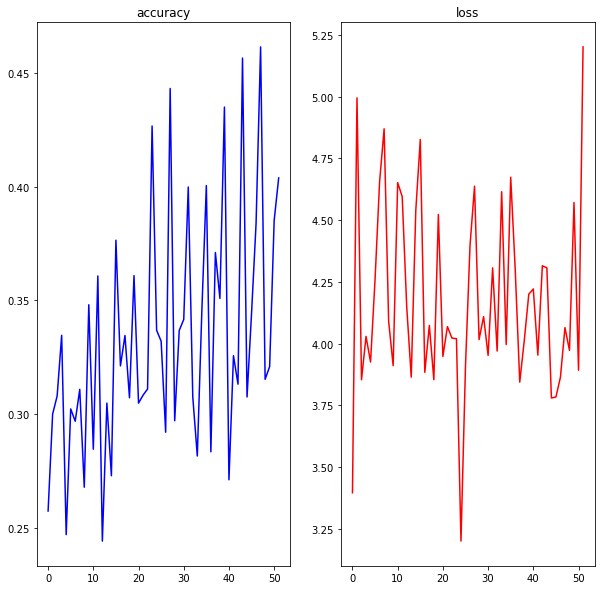

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.plot(range(0, len(test_acc)), test_acc, color="blue")
ax1.set_title("accuracy")
ax2.plot(range(0, len(test_acc)), test_loss, color="red")
ax2.set_title("loss")

In [13]:
# where max acc? and where min loss?
print("highest accuracy {0} and index {1}".format(
    round(max(test_acc), 2),
    test_acc.index(max(test_acc))
    ))
print("nMFCCs highets acc: {}".format(
    num_mfcc[int(test_acc.index(max(test_acc))/4)]
    ))
print("sr highest accuracy: {}".format(
    srs[test_acc.index(max(test_acc)) % 4]
    ))
print("lowest loss {0} and index {1}".format(
    round(min(test_loss), 2),
    test_loss.index(min(test_loss))
    ))
print("nMFCCs lowest loss: {}".format(
    num_mfcc[int(test_loss.index(min(test_loss))/4)]
    ))
print("sr lowest loss: {}".format(
    srs[test_loss.index(min(test_loss)) % 4]
    ))

highest accuracy 0.46 and index 47
nMFCCs highets acc: 21
sr highest accuracy: 44800
lowest loss 3.2 and index 24
nMFCCs lowest loss: 16
sr lowest loss: 8000


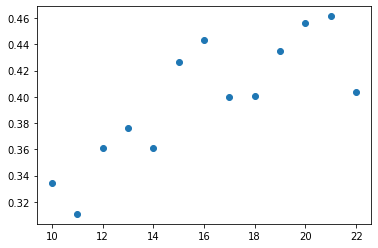

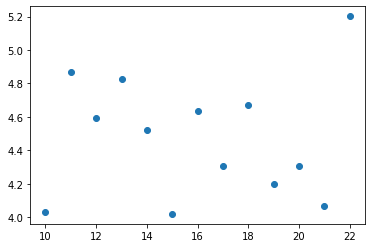

In [14]:
acc = []
which_mfcc_acc = []
loss = []
which_mfcc_loss = []
# go over the accuracy and loss of all n_mfccs and plot (taking into account only the best with sr=44.1kHz)
for i in range(3, len(test_acc), 4):
    acc.append(test_acc[i])
    which_mfcc_acc.append(num_mfcc[int(i / 4)])
    loss.append(test_loss[i])
    which_mfcc_loss.append(num_mfcc[int(i / 4)])

plt.figure()
plt.plot(which_mfcc_acc, acc, "o")

plt.figure()
plt.plot(which_mfcc_loss, loss, "o")

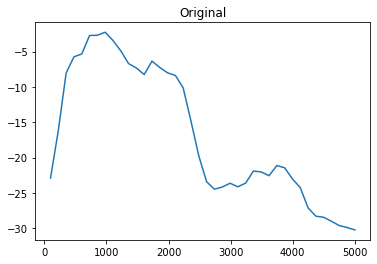

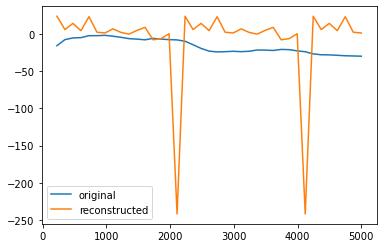

In [19]:
import librosa
import scipy as sc
import numpy as np

mel_spec = librosa.feature.melspectrogram(
    y=signals[100], sr=sr, fmin=100, fmax=5000,
    n_fft=1024, n_mels=40
)
log_mel_spec = librosa.power_to_db(mel_spec)

mel_feat = librosa.feature.mfcc(y=signals[100], sr=sr, n_mfcc=16, fmin=100, fmax=5000, n_fft=2048)
mel_feat = np.resize(mel_feat, log_mel_spec.shape)
rev_mel_feat = sc.fftpack.idct(mel_feat)
freq_ori = np.linspace(100, 5000, num=log_mel_spec.shape[0])

plt.figure()
plt.plot(freq_ori, np.mean(log_mel_spec, axis=1))
plt.title("Original")


plt.figure()
plt.plot(freq_ori[1:], np.mean(log_mel_spec, axis=1)[1:], label="original")
plt.plot(freq_ori[1:], np.mean(rev_mel_feat, axis=1)[1:], label="reconstructed")
plt.legend()